# Building Synthetic Dataset


#### Before running our algorithm on the movielens dataset, we decided to build a synthetic dataset and see if our algorithim would at least perform reasonably well in theory.

#### It is important to note that, while the dimensions of the matricies involved in recommender systems are extremely large, their rank is usually comparetively small. This is  why matrix factorization using SVD is a viable option.

In [60]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from copy import deepcopy
from numpy.linalg import matrix_rank

d = 100
r = 5

vec = (np.random.randint(9, size=(1,d))+1)/2
mat = vec*np.transpose(vec)
zer = np.zeros(mat.shape)

for i in range(r-1):
  zer[i][i] = 1

mat = mat + zer
min_a = np.amin(mat)
max_a = np.amax(mat)
range_a = max_a - min_a

data = 4.5*((mat - min_a)/range_a) + 0.5
data = np.round(2*data)/2

u,m = data.shape
print("Rank:", matrix_rank(data))
print("Dataset Shape:", data.shape)
print(data)

Rank: 10
Dataset Shape: (100, 100)
[[2.5 1.  1.5 ... 1.  3.5 2. ]
 [1.  0.5 0.5 ... 0.5 1.  0.5]
 [1.5 0.5 1.  ... 1.  2.  1.5]
 ...
 [1.  0.5 1.  ... 0.5 1.5 1. ]
 [3.5 1.  2.  ... 1.5 5.  3. ]
 [2.  0.5 1.5 ... 1.  3.  2. ]]


In [61]:
from scipy.sparse.linalg import svds
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error as mae

densities = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.05]
MAE = []
for i, density in enumerate(densities):
  train_select = np.random.choice(a=[False, True], size=(u,m), p=[1-density, density])
  test_select = np.logical_not(train_select)

  train = deepcopy(data)
  train[test_select] = np.nan

  test = deepcopy(data)
  test[train_select] = np.nan

  print("Density:", density)
  # print("Train Num Count:", (~np.isnan(train)).sum())
  # print("Test Num Count:", (~np.isnan(test)).sum())

  mean_rating = np.nanmean(train, axis=0)
  inds = np.where(np.isnan(train))
  train[inds] = np.take(mean_rating, inds[1])

  reconstruction = train
  for j in range(20):
    U, sigma, Vt = svds(reconstruction, 20)
    sigma = np.diag(sigma)

    reconstruction = np.round(2*(np.dot(np.dot(U, sigma), Vt)))/2
    reconstruction[train_select] = train[train_select]

    reconstruction[reconstruction > 5] = 5
    reconstruction[reconstruction < 0.5] = 0.5

  reconstruction = np.round(2*(np.dot(np.dot(U, sigma), Vt)))/2
  result = reconstruction[test_select].flatten() 
  ground_truth = test[test_select].flatten()
  
  cm = confusion_matrix(ground_truth*2, result*2)
  MAE.append(mae(result,ground_truth))
  #CCR.append(100*(np.trace(cm)/np.sum(cm)))

  # print("CCR:", CCR[i])
  # print()

Density: 0.9
Density: 0.8
Density: 0.7
Density: 0.6
Density: 0.5
Density: 0.4
Density: 0.3
Density: 0.2
Density: 0.1
Density: 0.05


Dataset Shape: (100, 100)
Dataset rank: 10
Minimum CCR: 0.24%


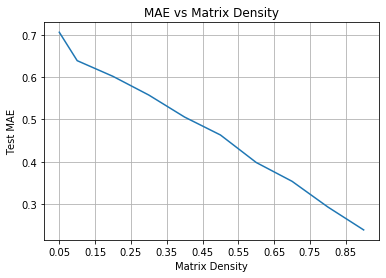

In [69]:
from matplotlib import pyplot as plt

plt.plot(densities, MAE)
plt.xlabel('Matrix Density')
plt.ylabel('Test MAE')
plt.xticks(np.arange(min(densities), max(densities), 0.1))
#plt.xticks(densities)
plt.title("MAE vs Matrix Density")
plt.grid()

print("Dataset Shape:", data.shape)
print("Dataset rank:", matrix_rank(data))
print("Minimum CCR:", "{0:0.2f}".format(min(MAE)) + '%')


# plt.savefig("abc.png")

In [57]:
from scipy.sparse.linalg import svds
from sklearn.metrics import confusion_matrix

density = 0.2

train_select = np.random.choice(a=[False, True], size=(u,m), p=[1-density, density])
test_select = np.logical_not(train_select)

train = deepcopy(data)
train[test_select] = np.nan

test = deepcopy(data)
test[train_select] = np.nan

print("Density:", density)
print("Train Num Count:", (~np.isnan(train)).sum())
print("Test Num Count:", (~np.isnan(test)).sum())

mean_rating = np.nanmean(train, axis=0)
inds = np.where(np.isnan(train))
train[inds] = np.take(mean_rating, inds[1])

Density: 0.2
Train Num Count: 2013
Test Num Count: 7987


In [58]:
from scipy.sparse.linalg import svds
from sklearn.metrics import confusion_matrix

density = 0.2

train_select = np.random.choice(a=[False, True], size=(u,m), p=[1-density, density])
test_select = np.logical_not(train_select)

train = deepcopy(data)
train[test_select] = np.nan

test = deepcopy(data)
test[train_select] = np.nan

print("Density:", density)
print("Train Num Count:", (~np.isnan(train)).sum())
print("Test Num Count:", (~np.isnan(test)).sum())

mean_rating = np.nanmean(train, axis=0)
inds = np.where(np.isnan(train))
train[inds] = np.take(mean_rating, inds[1])

tmax = 10
MAE = []
reconstruction = train
for t in range(tmax):
  print(t)
  U, sigma, Vt = svds(reconstruction, 20)
  sigma = np.diag(sigma)

  reconstruction = np.round(2*(np.dot(np.dot(U, sigma), Vt)))/2
  reconstruction[train_select] = train[train_select]

  reconstruction[reconstruction > 5] = 5
  reconstruction[reconstruction < 0.5] = 0.5

  reconstruction = np.round(2*(np.dot(np.dot(U, sigma), Vt)))/2
  result = reconstruction[test_select].flatten() 
  ground_truth = test[test_select].flatten()

  cm = confusion_matrix(ground_truth*2, result*2)

  MAE.append(mae(result,ground_truth))

Density: 0.2
Train Num Count: 1938
Test Num Count: 8062
0
1
2
3
4
5
6
7
8
9


Dataset Shape: (100, 100)
Dataset rank: 9


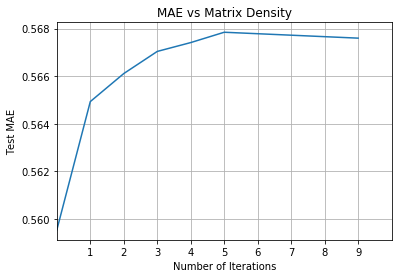

In [59]:
plt.plot(list(range(tmax)), MAE)
plt.xlabel('Number of Iterations')
plt.ylabel('Test MAE')
plt.xticks(np.arange(1, 10, 1))
plt.xlim(0,10)
plt.title("MAE vs Matrix Density")
plt.grid()

print("Dataset Shape:", data.shape)
print("Dataset rank:", matrix_rank(data))
#print("Maximum CCR:", "{0:0.2f}".format(max(MMR)) + '%', 'happens at the', MMR.index(max(MMR)), 'iteration')


# plt.savefig("abc.png")